In [12]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, correlation
import reclab

In [13]:
# Beta vs Pearson correlation

# np.random.seed(0)

def correlation_train(beta, correlation_metric):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='latent-dynamic-v1')
    users, items, ratings, P, R = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta)
    return correlation(P, truth, correlation_metric)


beta = np.linspace(0.01, 10, 10)
correlation = [correlation_train(i, 'spearman') for i in beta]
print(correlation)


[1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0]


/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_6164/1632256913.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


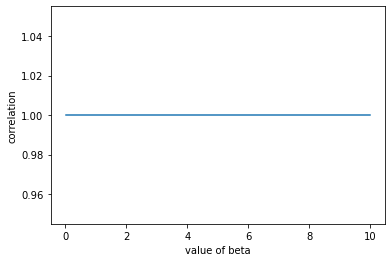

In [14]:
fig, ax = plt.subplots()
ax.plot(beta, correlation)
ax.set(xlabel='value of beta', ylabel='correlation')
fig.show()

In [26]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='latent-dynamic-v1')
    users, items, ratings, P, R = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta)
    return P, R

beta = np.linspace(0.01, 3, 6)
results = [P_R_train(i) for i in beta]     

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_6164/2644875088.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


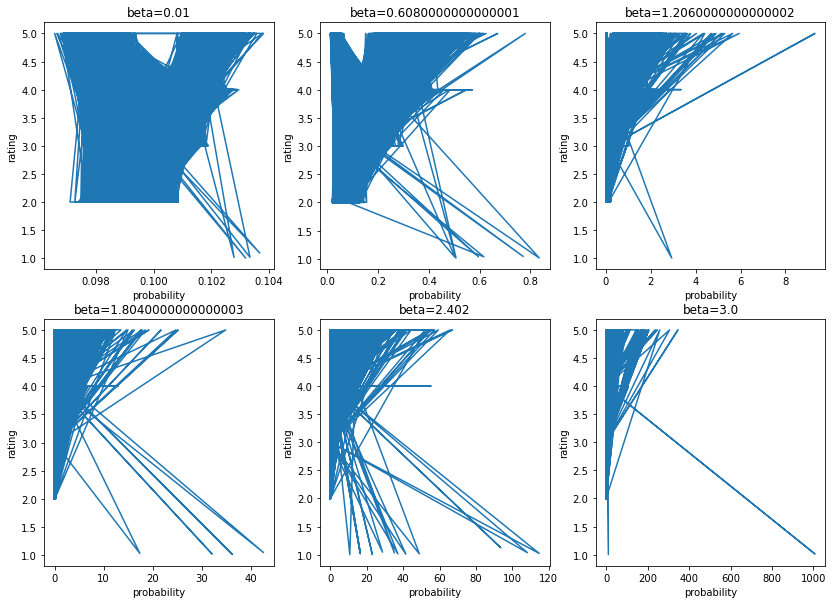

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    axs[i // 3, i % 3].plot(results[i][0].flatten(), results[i][1].flatten())
    axs[i // 3, i % 3].set(xlabel='probability',
                           ylabel='rating', title=f'beta={beta[i]}')
fig.show()

In [25]:
# Experiment begins
import surprise

5
